In [66]:
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [67]:
pd.set_option('display.max_columns', 999)
%matplotlib inline
mpl.rcParams['figure.facecolor'] = 'white'

In [68]:
HOME_TEAM = "England"
AWAY_TEAM = "Germany"
PITCH_MAX_X = 105
PITCH_MAX_Y = 68

In [69]:
def extract_json_from_html(html_path, save_output=False):
    html_file = open(html_path, 'r')
    html = html_file.read()
    html_file.close()
    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for json parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')

    if save_output:
        # save json data to txt
        output_file = open(f"{html_path}.txt", "wt")
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt

In [70]:
def extract_data_from_dict(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df = pd.concat([players_home_df, players_away_df])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_dict, players_df, teams_dict

In [71]:
match_html_path = './reasources/htmls/England 2-0 Germany - European Championship 2020 Live.html'
json_data_txt = extract_json_from_html(match_html_path)

In [72]:
data = json.loads(json_data_txt)
events_dict, players_df, teams_dict = extract_data_from_dict(data)

In [73]:
teams_dict

{345: 'England', 336: 'Germany'}

In [74]:
players_df.head()

,playerId,shirtNo,name,position,height,weight,age,isFirstEleven,isManOfTheMatch,field,stats,subbedInPlayerId,subbedOutPeriod,subbedOutExpandedMinute,subbedInPeriod,subbedInExpandedMinute,subbedOutPlayerId,teamId
0,110189,1,Jordan Pickford,GK,185,77,27,True,False,home,"{'totalSaves': {'3': 1.0, '31': 1.0, '49': 1.0...",NaN,NaN,NaN,NaN,NaN,NaN,345
1,69778,2,Kyle Walker,DC,178,70,31,True,False,home,"{'possession': {'0': 1.0, '1': 1.0, '2': 1.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,345
2,99487,6,Harry Maguire,DC,194,100,28,True,True,home,"{'possession': {'0': 2.0, '4': 2.0, '5': 1.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,345
3,101374,5,John Stones,DC,188,70,27,True,False,home,"{'possession': {'0': 1.0, '4': 2.0, '5': 1.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,345
4,83078,12,Kieran Trippier,DMR,178,71,30,True,False,home,"{'possession': {'4': 2.0, '6': 1.0, '11': 1.0,...",NaN,NaN,NaN,NaN,NaN,NaN,345


In [75]:
df = pd.DataFrame(events_dict)
df.head()

,id,eventId,minute,second,teamId,x,y,expandedMinute,period,type,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,playerId,endX,endY,blockedX,blockedY,goalMouthZ,goalMouthY,isShot,cardType,relatedEventId,relatedPlayerId,isGoal
0,2.308643e+09,2,0,0.0,345,0.0,0.0,0,"{'value': 1, 'displayName': 'FirstHalf'}","{'value': 32, 'displayName': 'Start'}","{'value': 1, 'displayName': 'Successful'}",[],[],False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.308643e+09,2,0,0.0,336,0.0,0.0,0,"{'value': 1, 'displayName': 'FirstHalf'}","{'value': 32, 'displayName': 'Start'}","{'value': 1, 'displayName': 'Successful'}",[],[],False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.308643e+09,3,0,1.0,336,49.8,50.0,0,"{'value': 1, 'displayName': 'FirstHalf'}","{'value': 1, 'displayName': 'Pass'}","{'value': 1, 'displayName': 'Successful'}","[{'type': {'value': 140, 'displayName': 'PassE...","[90, 116, 29, 34, 36, 215, 217]",True,130903.0,36.0,56.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.308643e+09,4,0,2.0,336,35.7,56.6,0,"{'value': 1, 'displayName': 'FirstHalf'}","{'value': 1, 'displayName': 'Pass'}","{'value': 1, 'displayName': 'Successful'}","[{'type': {'value': 56, 'displayName': 'Zone'}...","[90, 116, 29, 34, 37, 215, 217]",True,31772.0,34.5,46.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.308643e+09,5,0,3.0,336,33.8,46.3,0,"{'value': 1, 'displayName': 'FirstHalf'}","{'value': 1, 'displayName': 'Pass'}","{'value': 1, 'displayName': 'Successful'}","[{'type': {'value': 140, 'displayName': 'PassE...","[90, 116, 29, 34, 36, 214, 217]",True,115519.0,26.9,52.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
df.columns

Index(['id', 'eventId', 'minute', 'second', 'teamId', 'x', 'y',
       'expandedMinute', 'period', 'type', 'outcomeType', 'qualifiers',
       'satisfiedEventsTypes', 'isTouch', 'playerId', 'endX', 'endY',
       'blockedX', 'blockedY', 'goalMouthZ', 'goalMouthY', 'isShot',
       'cardType', 'relatedEventId', 'relatedPlayerId', 'isGoal'],
      dtype='object')

In [77]:
df = pd.DataFrame(events_dict)

df["eventType"] = df.apply(lambda row: row["type"]["displayName"], axis=1)
df["outcomeType"] = df.apply(lambda row: row["outcomeType"]["displayName"], axis=1)
df["half"] = df.apply(lambda row: row["period"]["displayName"], axis=1)

df["x"] = df["x"].apply(lambda row: row / 100 * PITCH_MAX_X)
df["endX"] = df["endX"].apply(lambda row: row / 100 * PITCH_MAX_X)
df["y"] = df["y"].apply(lambda row: row / 100 * PITCH_MAX_Y)
df["endY"] = df["endY"].apply(lambda row: row / 100 * PITCH_MAX_Y)

df["time"] = df["minute"] + df["second"] / 100

df.replace(teams_dict, inplace=True)

recivers= []
for idx, row in df.iterrows():
    if row["eventType"] == "Pass":
        recivers.append(df.iloc[idx+1, 14])
    else:
        recivers.append(np.nan)
df["reciverId"] = recivers

df.drop(columns=["id", "period", "type", "minute", "second"], inplace=True)
# TODO change columns order
df.head()

,eventId,teamId,x,y,expandedMinute,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,playerId,endX,endY,blockedX,blockedY,goalMouthZ,goalMouthY,isShot,cardType,relatedEventId,relatedPlayerId,isGoal,eventType,half,time,reciverId
0,2,England,0.000,0.000,0,Successful,[],[],False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Start,FirstHalf,0.00,NaN
1,2,Germany,0.000,0.000,0,Successful,[],[],False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Start,FirstHalf,0.00,NaN
2,3,Germany,52.290,34.000,0,Successful,"[{'type': {'value': 140, 'displayName': 'PassE...","[90, 116, 29, 34, 36, 215, 217]",True,130903.0,37.800,38.352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pass,FirstHalf,0.01,31772.0
3,4,Germany,37.485,38.488,0,Successful,"[{'type': {'value': 56, 'displayName': 'Zone'}...","[90, 116, 29, 34, 37, 215, 217]",True,31772.0,36.225,31.688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pass,FirstHalf,0.02,115519.0
4,5,Germany,35.490,31.484,0,Successful,"[{'type': {'value': 140, 'displayName': 'PassE...","[90, 116, 29, 34, 36, 214, 217]",True,115519.0,28.245,35.904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pass,FirstHalf,0.03,21541.0


In [78]:
df.loc[2, "qualifiers"]

[{'type': {'value': 140, 'displayName': 'PassEndX'}, 'value': '36.0'},
 {'type': {'value': 56, 'displayName': 'Zone'}, 'value': 'Back'},
 {'type': {'value': 213, 'displayName': 'Angle'}, 'value': '2.8'},
 {'type': {'value': 212, 'displayName': 'Length'}, 'value': '15.1'},
 {'type': {'value': 141, 'displayName': 'PassEndY'}, 'value': '56.4'}]

In [79]:
FIRST_HOME_SUB = df[(df.eventType == 'SubstitutionOn') & (df.teamId == HOME_TEAM)]["time"].head(1).item()
FIRST_AWAY_SUB = df[(df.eventType == 'SubstitutionOn') & (df.teamId == AWAY_TEAM)]["time"].head(1).item()

In [81]:
passes = df.loc[df.index[df.eventType == "Pass"], ["teamId", "playerId", "x", "y", "endX", "endY", "outcomeType", "half", "time"]]
passes

,teamId,playerId,x,y,endX,endY,outcomeType,half,time
2,Germany,130903.0,52.290,34.000,37.800,38.352,Successful,FirstHalf,0.01
3,Germany,31772.0,37.485,38.488,36.225,31.688,Successful,FirstHalf,0.02
4,Germany,115519.0,35.490,31.484,28.245,35.904,Successful,FirstHalf,0.03
5,Germany,21541.0,28.245,35.904,35.805,4.624,Successful,FirstHalf,0.05
6,Germany,283323.0,34.020,10.200,88.620,34.680,Unsuccessful,FirstHalf,0.09
...,...,...,...,...,...,...,...,...,...
1503,Germany,144711.0,71.820,50.660,75.180,43.248,Unsuccessful,SecondHalf,93.55
1504,England,270446.0,28.875,29.308,38.220,35.428,Unsuccessful,SecondHalf,93.55
1505,Germany,111212.0,64.260,33.796,67.410,15.640,Successful,SecondHalf,93.58
1506,Germany,31772.0,67.200,16.728,94.500,37.944,Unsuccessful,SecondHalf,94.01


In [83]:
england_passes = passes[(passes.teamId == HOME_TEAM)]
england_passes

,teamId,playerId,x,y,endX,endY,outcomeType,half,time
8,England,110189.0,15.435,31.484,28.770,17.612,Successful,FirstHalf,0.15
9,England,69778.0,28.980,17.544,29.295,25.160,Successful,FirstHalf,0.17
10,England,101374.0,28.140,25.636,31.920,52.904,Successful,FirstHalf,0.19
11,England,99487.0,35.805,55.420,55.440,59.908,Successful,FirstHalf,0.23
12,England,97692.0,49.140,60.316,37.905,59.024,Successful,FirstHalf,0.26
...,...,...,...,...,...,...,...,...,...
1458,England,110189.0,4.830,38.012,64.995,52.292,Unsuccessful,SecondHalf,91.43
1464,England,270446.0,55.650,47.532,82.845,51.952,Unsuccessful,SecondHalf,91.50
1477,England,118244.0,24.780,44.676,36.645,41.004,Successful,SecondHalf,92.16
1484,England,110189.0,15.435,55.216,90.930,46.308,Unsuccessful,SecondHalf,92.47


In [84]:
england_passes[["x", "y", "endX", "endY"]].describe()

,x,y,endX,endY
count,479.000000,479.000000,479.000000,479.000000
mean,49.901962,32.025587,54.939770,32.954163
std,22.115305,20.373126,22.940908,20.400474
min,3.150000,0.000000,1.470000,0.000000
25%,34.387500,12.818000,37.747500,14.756000
50%,49.875000,32.572000,55.230000,33.320000
75%,65.572500,49.300000,69.720000,51.578000
max,104.475000,68.000000,105.000000,68.000000


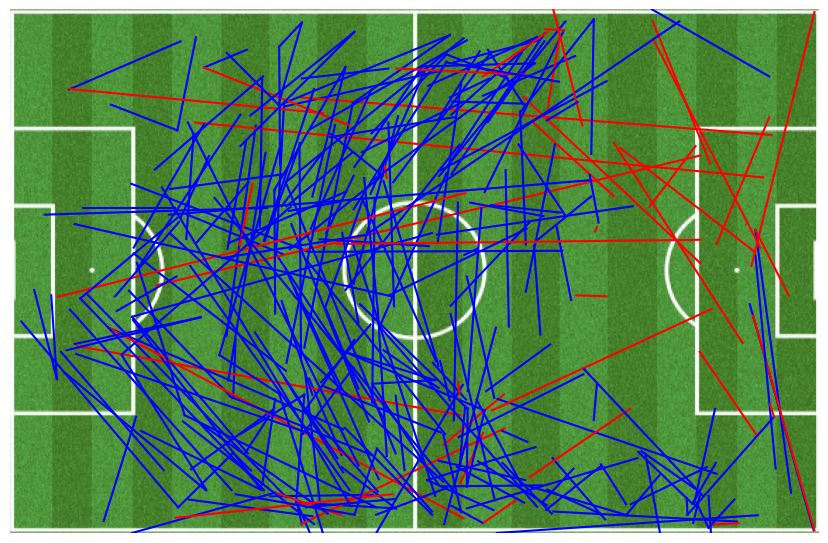

In [87]:
plt.figure(figsize=(PITCH_MAX_X/10, PITCH_MAX_Y / 10))
plt.xlim((0, PITCH_MAX_X))
plt.ylim((0, PITCH_MAX_Y))
plt.axis("off")
im = plt.imread("./reasources/images/football_pitch_resized.png")
plt.imshow(im, extent=[0, PITCH_MAX_X, 0, PITCH_MAX_Y])

for idx, row in england_passes.iterrows():
    if row["half"] == "FirstHalf":
        x_values = (row["x"], row["endX"])
        y_values = (row["y"], row["endY"])
        color = "blue" if row["outcomeType"] == "Successful" else "red"
        plt.plot(x_values, y_values, color=color)
plt.show()

England's goalkeeper passes

In [86]:
england_goalkeeper_passes = england_passes[england_passes["playerId"] == 110189]
england_goalkeeper_passes.head()

,teamId,playerId,x,y,endX,endY,outcomeType,half,time
8,England,110189.0,15.435,31.484,28.770,17.612,Successful,FirstHalf,0.15
26,England,110189.0,24.045,53.312,97.860,46.172,Unsuccessful,FirstHalf,1.49
67,England,110189.0,10.080,30.940,35.910,4.624,Successful,FirstHalf,4.06
86,England,110189.0,8.715,24.276,58.485,15.300,Unsuccessful,FirstHalf,5.01
103,England,110189.0,16.485,34.204,29.925,54.332,Successful,FirstHalf,5.47


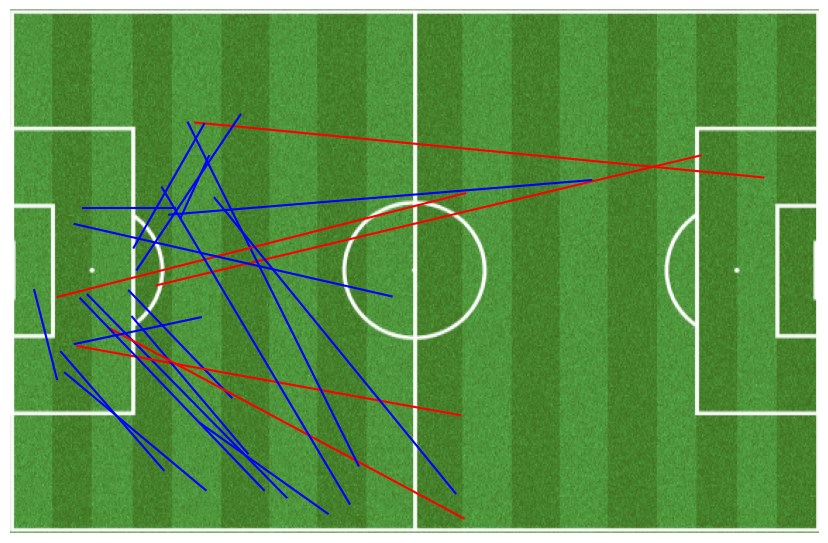

In [88]:
plt.figure(figsize=(PITCH_MAX_X / 10, PITCH_MAX_Y / 10))
plt.xlim((0, PITCH_MAX_X))
plt.ylim((0, PITCH_MAX_Y))
plt.axis("off")
im = plt.imread("./reasources/images/football_pitch_resized.png")
plt.imshow(im, extent=[0, PITCH_MAX_X, 0, PITCH_MAX_Y])

for idx, row in england_goalkeeper_passes.iterrows():
    if row["half"] == "FirstHalf":
        x_values = (row["x"], row["endX"])
        y_values = (row["y"], row["endY"])
        color = "blue" if row["outcomeType"] == "Successful" else "red"
        plt.plot(x_values, y_values, color=color)
plt.show()

In [29]:
avg_position = england_passes.groupby(["playerId"])[["x", "y"]].mean()
avg_position

,x,y
playerId,,
69778.0,46.166321,15.504000
83078.0,63.140700,10.703200
83532.0,63.778750,42.953333
97692.0,63.015750,53.393600
99487.0,44.270930,49.923070
101374.0,36.404118,29.374667
110189.0,13.992222,34.745481
118244.0,54.417794,60.720000
270446.0,53.950909,24.571182


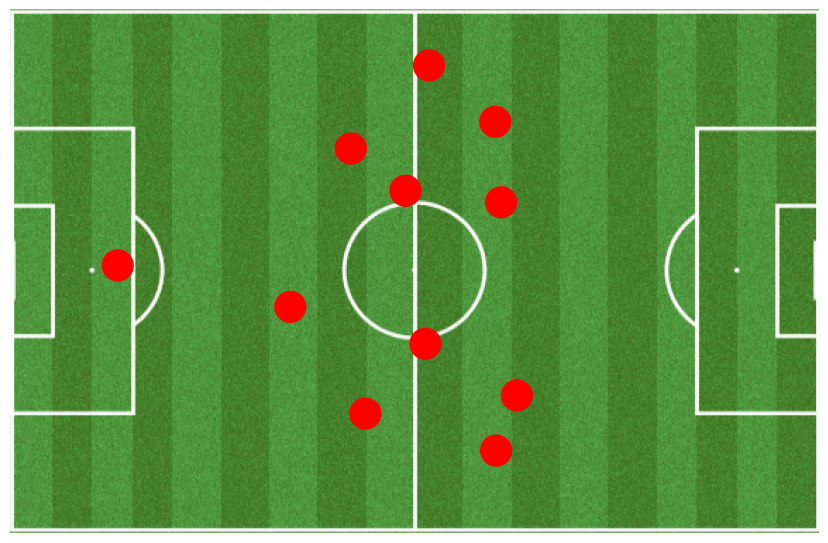

In [30]:
plt.figure(figsize=(PITCH_MAX_X / 10, PITCH_MAX_Y / 10))
plt.xlim((0, PITCH_MAX_X))
plt.ylim((0, PITCH_MAX_Y))
plt.axis("off")
im = plt.imread("./reasources/images/football_pitch_resized.png")
plt.imshow(im, extent=[0, PITCH_MAX_X, 0, PITCH_MAX_Y])

for row in avg_position.iterrows():
    player_circle = plt.Circle((row[1]["x"], row[1]["y"]), 2, color="r")
    plt.gca().add_patch(player_circle)
plt.show()

In [90]:
df.head()

,eventId,teamId,x,y,expandedMinute,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,playerId,endX,endY,blockedX,blockedY,goalMouthZ,goalMouthY,isShot,cardType,relatedEventId,relatedPlayerId,isGoal,eventType,half,time,reciverId
0,2,England,0.000,0.000,0,Successful,[],[],False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Start,FirstHalf,0.00,NaN
1,2,Germany,0.000,0.000,0,Successful,[],[],False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Start,FirstHalf,0.00,NaN
2,3,Germany,52.290,34.000,0,Successful,"[{'type': {'value': 140, 'displayName': 'PassE...","[90, 116, 29, 34, 36, 215, 217]",True,130903.0,37.800,38.352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pass,FirstHalf,0.01,31772.0
3,4,Germany,37.485,38.488,0,Successful,"[{'type': {'value': 56, 'displayName': 'Zone'}...","[90, 116, 29, 34, 37, 215, 217]",True,31772.0,36.225,31.688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pass,FirstHalf,0.02,115519.0
4,5,Germany,35.490,31.484,0,Successful,"[{'type': {'value': 140, 'displayName': 'PassE...","[90, 116, 29, 34, 36, 214, 217]",True,115519.0,28.245,35.904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pass,FirstHalf,0.03,21541.0


In [92]:
df[(df.teamId == HOME_TEAM) & (df.eventType == "Pass")].groupby(['playerId', 'reciverId']).size().reset_index(name="Count")

,playerId,reciverId,Count
0,69778.0,13754.0,2
1,69778.0,21541.0,1
2,69778.0,31772.0,2
3,69778.0,83078.0,9
4,69778.0,83532.0,1
...,...,...,...
153,367185.0,115519.0,1
154,367185.0,141726.0,1
155,367185.0,270446.0,1
156,367185.0,283323.0,1


In [31]:
england_df = df.loc[df.teamId == "England"]
england_df.head()

,id,eventId,minute,second,teamId,x,y,expandedMinute,period,type,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,playerId,endX,endY,blockedX,blockedY,goalMouthZ,goalMouthY,isShot,cardType,relatedEventId,relatedPlayerId,isGoal,eventType,half
0,2.308643e+09,2,0,0.0,England,0.0,0.0,0,"{'value': 1, 'displayName': 'FirstHalf'}","{'value': 32, 'displayName': 'Start'}",Successful,[],[],False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Start,FirstHalf
7,2.308643e+09,3,0,14.0,England,15.1,49.3,0,"{'value': 1, 'displayName': 'FirstHalf'}","{'value': 52, 'displayName': 'KeeperPickup'}",Successful,[],[92],False,110189.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KeeperPickup,FirstHalf
8,2.308643e+09,4,0,15.0,England,14.7,46.3,0,"{'value': 1, 'displayName': 'FirstHalf'}","{'value': 1, 'displayName': 'Pass'}",Successful,"[{'type': {'value': 213, 'displayName': 'Angle...","[90, 35, 37, 214, 217]",True,110189.0,27.4,25.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pass,FirstHalf
9,2.308643e+09,5,0,17.0,England,27.6,25.8,0,"{'value': 1, 'displayName': 'FirstHalf'}","{'value': 1, 'displayName': 'Pass'}",Successful,"[{'type': {'value': 213, 'displayName': 'Angle...","[90, 116, 29, 35, 36, 214, 217]",True,69778.0,27.9,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pass,FirstHalf
10,2.308643e+09,6,0,19.0,England,26.8,37.7,0,"{'value': 1, 'displayName': 'FirstHalf'}","{'value': 1, 'displayName': 'Pass'}",Successful,"[{'type': {'value': 213, 'displayName': 'Angle...","[90, 116, 29, 35, 36, 214, 217]",True,101374.0,30.4,77.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pass,FirstHalf


In [32]:
idx_to_drop = england_df[(england_df.eventType == "Pass") & (england_df.outcomeType == "Unsuccessful")].index
england_df.drop(idx_to_drop, inplace=True)
england_df.head()

C:\Users\Jędrek\AppData\Local\Temp\ipykernel_11708\2460806477.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  england_df.drop(idx_to_drop, inplace=True)


,id,eventId,minute,second,teamId,x,y,expandedMinute,period,type,outcomeType,qualifiers,satisfiedEventsTypes,isTouch,playerId,endX,endY,blockedX,blockedY,goalMouthZ,goalMouthY,isShot,cardType,relatedEventId,relatedPlayerId,isGoal,eventType,half
0,2.308643e+09,2,0,0.0,England,0.0,0.0,0,"{'value': 1, 'displayName': 'FirstHalf'}","{'value': 32, 'displayName': 'Start'}",Successful,[],[],False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Start,FirstHalf
7,2.308643e+09,3,0,14.0,England,15.1,49.3,0,"{'value': 1, 'displayName': 'FirstHalf'}","{'value': 52, 'displayName': 'KeeperPickup'}",Successful,[],[92],False,110189.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KeeperPickup,FirstHalf
8,2.308643e+09,4,0,15.0,England,14.7,46.3,0,"{'value': 1, 'displayName': 'FirstHalf'}","{'value': 1, 'displayName': 'Pass'}",Successful,"[{'type': {'value': 213, 'displayName': 'Angle...","[90, 35, 37, 214, 217]",True,110189.0,27.4,25.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pass,FirstHalf
9,2.308643e+09,5,0,17.0,England,27.6,25.8,0,"{'value': 1, 'displayName': 'FirstHalf'}","{'value': 1, 'displayName': 'Pass'}",Successful,"[{'type': {'value': 213, 'displayName': 'Angle...","[90, 116, 29, 35, 36, 214, 217]",True,69778.0,27.9,37.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pass,FirstHalf
10,2.308643e+09,6,0,19.0,England,26.8,37.7,0,"{'value': 1, 'displayName': 'FirstHalf'}","{'value': 1, 'displayName': 'Pass'}",Successful,"[{'type': {'value': 213, 'displayName': 'Angle...","[90, 116, 29, 35, 36, 214, 217]",True,101374.0,30.4,77.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pass,FirstHalf


In [35]:
nop = england_number_of_passes.groupby(['playerId', 'reciverId']).size().reset_index(name="Count")
nop

,playerId,reciverId,Count
0,69778.0,69778.0,1
1,69778.0,83078.0,5
2,69778.0,83532.0,2
3,69778.0,99487.0,4
4,69778.0,101374.0,9
...,...,...,...
85,367185.0,83078.0,6
86,367185.0,83532.0,2
87,367185.0,101374.0,3
88,367185.0,270446.0,1


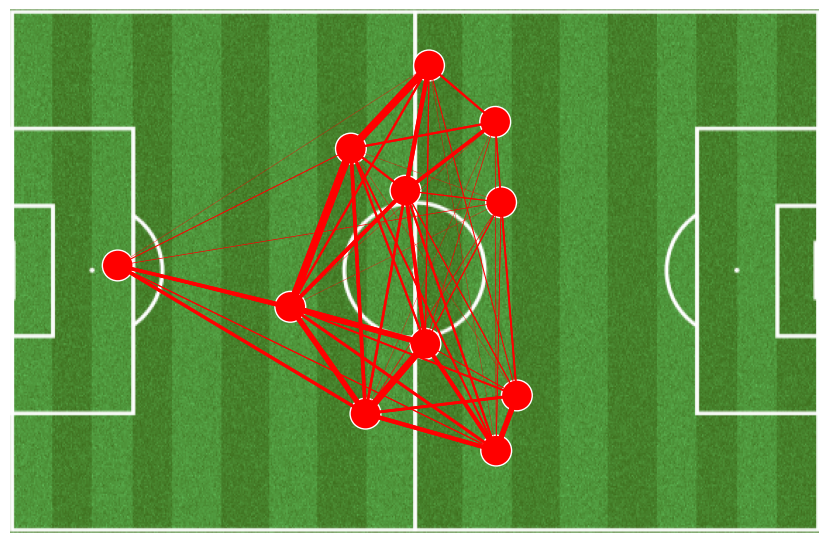

In [36]:
plt.figure(figsize=(PITCH_MAX_X / 10, PITCH_MAX_Y / 10))
plt.xlim((0, PITCH_MAX_X))
plt.ylim((0, PITCH_MAX_Y))
plt.axis("off")
im = plt.imread("./reasources/images/football_pitch_resized.png")
plt.imshow(im, extent=[0, PITCH_MAX_X, 0, PITCH_MAX_Y])

for row in nop.iterrows():
    player_id, reciver_id, count = row[1]
    try:
        count += nop[(nop.playerId == reciver_id) & (nop.reciverId == player_id)]["Count"].item()
    except ValueError:
        pass
    x_values = (avg_position.loc[player_id, "x"], avg_position.loc[reciver_id, "x"])
    y_values = (avg_position.loc[player_id, "y"], avg_position.loc[reciver_id, "y"])
    plt.plot(x_values, y_values, color="r", linewidth=count/4)

for row in avg_position.iterrows():
    player_circle = plt.Circle((row[1]["x"], row[1]["y"]), radius=2, color="r", ec="white", label=players_df[players_df.playerId == row[1].name]["shirtNo"].item())
    plt.gca().add_patch(player_circle)


plt.show()

In [37]:
nop.pivot(index="playerId", columns="reciverId", values="Count")

reciverId,69778.0,83078.0,83532.0,97692.0,99487.0,101374.0,110189.0,118244.0,270446.0,332325.0,367185.0
playerId,,,,,,,,,,,
69778.0,1.0,5.0,2.0,NaN,4.0,9.0,5.0,NaN,11.0,2.0,5.0
83078.0,7.0,2.0,1.0,2.0,4.0,3.0,1.0,1.0,5.0,3.0,9.0
83532.0,NaN,1.0,NaN,2.0,NaN,NaN,NaN,NaN,1.0,2.0,3.0
97692.0,1.0,NaN,2.0,1.0,3.0,NaN,NaN,1.0,2.0,4.0,1.0
99487.0,6.0,1.0,1.0,3.0,NaN,11.0,NaN,11.0,2.0,3.0,1.0
101374.0,6.0,5.0,1.0,1.0,11.0,NaN,4.0,4.0,10.0,6.0,2.0
110189.0,4.0,2.0,2.0,NaN,3.0,6.0,NaN,1.0,2.0,NaN,NaN
118244.0,NaN,NaN,NaN,5.0,10.0,2.0,NaN,NaN,1.0,6.0,3.0
270446.0,8.0,6.0,2.0,NaN,4.0,6.0,2.0,2.0,NaN,8.0,1.0
